# Local Authority District (LAD) Economic Growth Summary 📈

This notebook processes UK Local Authority District (LAD) economic growth data, focusing on GDP per head growth across different years. 

The dataset is sourced from [the Office for National Statistics (ONS)](https://www.ons.gov.uk/businessindustryandtrade/business/activitysizeandlocation/adhocs/15241analysisofenterprisesintheukbylocalauthoritydistrict2022) and provides insights into economic trends at the local level.

Table 13, which reports GDP chained volume measures (CVM) per head annual growth rates as a percentage, was chosen because it accounts for population size, allowing fair comparisons between LADs. It also provides an annual growth rate, making it useful for analysing long-term trends and summarising economic performance effectively.


## Importing Modules 📚🔍

In [1]:
# !pip install statsmodels==0.14.4

In [2]:
import pandas as pd  # Data manipulation and analysis
from sklearn.decomposition import PCA  # For reducing the number of features in the data
from sklearn.preprocessing import StandardScaler  # To normalise the data for better results
import statsmodels.api as sm  # For statistical modelling and hypothesis testing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # For time series forecasting
import matplotlib.pyplot as plt  # For visualisation

## Data Preparation 🧼💦🫧

In [3]:
starter_path = '/work/LADS_data/lad_growth-gvt-data.csv'  # Update with correct path if needed in future
output_path = '/work/LADS_data/lad_growth_with_forecast.csv'  # Update with output path if needed in future

In [4]:
lad_growth_gvt = pd.read_csv(starter_path, skiprows=1)  # Skip header row which is otherwise "Unnamed: 0"
lad_growth_gvt

,ITL1 Region,LA code,LA name,1999,2000,2001,2002,2003,2004,2005,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,North East,E06000001,Hartlepool,6.1,0.1,-0.4,2.0,2.0,0.6,-1.1,...,0.3,-2.9,5.4,7.5,-1.2,-3.4,-1.4,-3.7,-4.5,3.6
1,North East,E06000004,Stockton-on-Tees,4.4,0.2,0.7,1.5,4.4,4.7,-2.0,...,0.2,1.7,5.6,-0.5,-3.3,-0.2,2.6,-7.2,9.0,0.8
2,North East,E06000002,Middlesbrough,4.3,1.9,0.4,1.5,3.8,5.6,2.3,...,-2.4,1.1,2.9,2.7,3.7,4.7,-3.1,-19.1,17.3,3.8
3,North East,E06000003,Redcar and Cleveland,4.0,2.5,-2.4,2.7,5.9,-0.6,-1.2,...,-2.2,3.8,2.9,-4.8,-7.3,2.7,-0.3,-7.6,0.7,3.4
4,North East,E06000005,Darlington,7.6,15.2,11.0,8.5,9.3,8.8,-0.5,...,1.7,15.9,10.5,-3.3,1.6,2.7,-0.9,-13.2,13.1,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,Northern Ireland,N09000004,Causeway Coast and Glens,6.9,9.7,0.8,0.0,3.3,0.4,4.2,...,-0.2,1.0,-2.2,5.2,2.0,-3.0,0.4,-13.5,11.3,2.7
357,Northern Ireland,N09000001,Antrim and Newtownabbey,5.4,6.6,3.4,-0.7,1.0,1.4,1.3,...,-1.6,4.8,0.1,2.0,3.7,-0.3,1.9,-14.8,11.7,1.2
358,Northern Ireland,N09000007,Lisburn and Castlereagh,4.9,5.9,3.9,-1.1,2.6,-0.2,2.8,...,0.4,1.4,2.5,3.1,0.2,1.7,2.5,-15.4,12.5,4.4
359,Northern Ireland,N09000008,Mid and East Antrim,-4.1,3.6,-3.6,2.3,-1.8,3.0,-0.3,...,-3.7,-6.8,4.2,-7.6,-14.2,-14.9,1.6,-8.0,5.4,0.7


In [5]:
lad_growth_gvt.columns = ["Region", "LA Code", "LA Name"] + lad_growth_gvt.columns[3:].tolist() #  Rename columns
lad_growth_gvt

,Region,LA Code,LA Name,1999,2000,2001,2002,2003,2004,2005,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,North East,E06000001,Hartlepool,6.1,0.1,-0.4,2.0,2.0,0.6,-1.1,...,0.3,-2.9,5.4,7.5,-1.2,-3.4,-1.4,-3.7,-4.5,3.6
1,North East,E06000004,Stockton-on-Tees,4.4,0.2,0.7,1.5,4.4,4.7,-2.0,...,0.2,1.7,5.6,-0.5,-3.3,-0.2,2.6,-7.2,9.0,0.8
2,North East,E06000002,Middlesbrough,4.3,1.9,0.4,1.5,3.8,5.6,2.3,...,-2.4,1.1,2.9,2.7,3.7,4.7,-3.1,-19.1,17.3,3.8
3,North East,E06000003,Redcar and Cleveland,4.0,2.5,-2.4,2.7,5.9,-0.6,-1.2,...,-2.2,3.8,2.9,-4.8,-7.3,2.7,-0.3,-7.6,0.7,3.4
4,North East,E06000005,Darlington,7.6,15.2,11.0,8.5,9.3,8.8,-0.5,...,1.7,15.9,10.5,-3.3,1.6,2.7,-0.9,-13.2,13.1,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,Northern Ireland,N09000004,Causeway Coast and Glens,6.9,9.7,0.8,0.0,3.3,0.4,4.2,...,-0.2,1.0,-2.2,5.2,2.0,-3.0,0.4,-13.5,11.3,2.7
357,Northern Ireland,N09000001,Antrim and Newtownabbey,5.4,6.6,3.4,-0.7,1.0,1.4,1.3,...,-1.6,4.8,0.1,2.0,3.7,-0.3,1.9,-14.8,11.7,1.2
358,Northern Ireland,N09000007,Lisburn and Castlereagh,4.9,5.9,3.9,-1.1,2.6,-0.2,2.8,...,0.4,1.4,2.5,3.1,0.2,1.7,2.5,-15.4,12.5,4.4
359,Northern Ireland,N09000008,Mid and East Antrim,-4.1,3.6,-3.6,2.3,-1.8,3.0,-0.3,...,-3.7,-6.8,4.2,-7.6,-14.2,-14.9,1.6,-8.0,5.4,0.7


In [6]:
lad_growth_gvt.info() # Check data types to confirm columns are numeric

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 27 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Region   361 non-null    object 
 1   LA Code  361 non-null    object 
 2   LA Name  361 non-null    object 
 3   1999     361 non-null    float64
 4   2000     361 non-null    float64
 5   2001     361 non-null    float64
 6   2002     361 non-null    float64
 7   2003     361 non-null    float64
 8   2004     361 non-null    float64
 9   2005     361 non-null    float64
 10  2006     361 non-null    float64
 11  2007     361 non-null    float64
 12  2008     361 non-null    float64
 13  2009     361 non-null    float64
 14  2010     361 non-null    float64
 15  2011     361 non-null    float64
 16  2012     361 non-null    float64
 17  2013     361 non-null    float64
 18  2014     361 non-null    float64
 19  2015     361 non-null    float64
 20  2016     361 non-null    float64
 21  2017     361 non

In [7]:
lad_growth_gvt.shape # Check the number of rows and columns

(361, 27)

### Check for missing values 🚫

In [8]:
lad_growth_gvt.isna().sum().sum() # Checks for total missing values

0

### Summary Statistics 📊

In [9]:
lad_growth_gvt.describe() # Summary statistics

,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
count,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,...,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.00000,361.000000
mean,3.266205,3.492521,2.054017,0.988643,2.471191,1.880886,1.547645,2.163989,0.091136,-1.456233,...,1.278116,2.515512,1.242105,0.724100,2.123269,0.628809,1.063158,-11.027701,9.11108,2.736288
std,2.704106,3.013004,2.653078,2.141977,2.239842,2.524831,2.359567,2.557436,3.320656,2.628861,...,2.784250,3.853647,3.478897,3.304845,3.762522,4.473086,3.384597,5.191859,4.93865,4.248377
min,-12.600000,-4.600000,-8.100000,-7.600000,-5.500000,-6.800000,-6.500000,-12.100000,-10.900000,-9.500000,...,-7.600000,-9.300000,-10.000000,-12.500000,-18.400000,-14.900000,-9.200000,-35.800000,-4.50000,-19.800000
25%,1.500000,1.700000,0.500000,-0.400000,0.900000,0.400000,-0.100000,0.800000,-2.000000,-3.200000,...,-0.200000,0.500000,-0.800000,-1.000000,0.000000,-1.200000,-0.800000,-13.800000,5.90000,0.500000
50%,3.200000,3.200000,2.000000,0.800000,2.500000,2.000000,1.500000,2.200000,-0.400000,-1.400000,...,1.200000,2.200000,1.100000,0.700000,2.000000,0.300000,1.000000,-10.900000,9.10000,2.700000
75%,4.600000,4.900000,3.400000,2.300000,3.800000,3.300000,2.800000,3.500000,1.300000,0.100000,...,2.800000,4.200000,3.100000,2.800000,4.000000,2.100000,2.600000,-8.300000,12.00000,5.100000
max,16.600000,18.200000,13.300000,10.000000,9.300000,12.500000,11.500000,12.300000,17.600000,7.900000,...,10.300000,39.600000,18.300000,11.000000,29.000000,57.800000,17.700000,11.900000,30.00000,18.700000


### The Boxplot of LADS' Economic Growth to Visualise the Average Growth Stats Above 📦

The boxplot visualises the distribution of LAD growth values for each year. It presents the spread of data:

- The middle line in each box represents the median
- The box itself shows the interquartile range (25th to 75th percentile)
- The whiskers extend to the lowest and highest non-outlier values
- Outliers are plotted as individual points

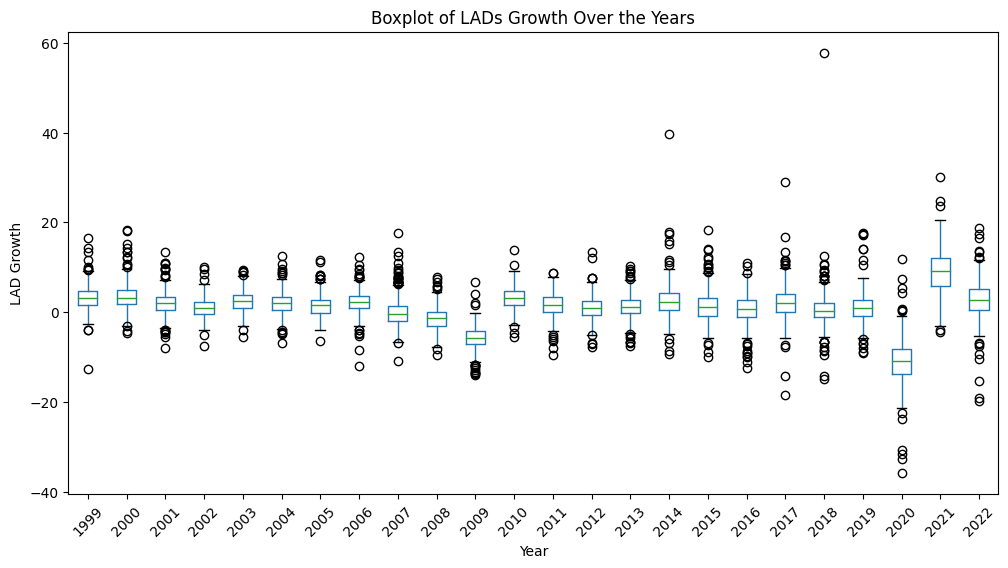

In [10]:
plt.figure(figsize=(12, 6))
lad_growth_gvt.boxplot()
plt.title("Boxplot of LADs Growth Over the Years")
plt.xlabel("Year")
plt.ylabel("LAD Growth")
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

#### Observations from the Boxplot 👆

- The LAD growth distribution remains fairly stable from 1999 to 2019, with median values mostly around the same level
- There are consistent outliers across all years, suggesting some LADs experienced unusual growth or decline
- A sharp drop is noticeable in 2020 and aligns with the COVID-19 pandemic impacting economic growth
- Growth recovers in 2021 and 2022, showing a wider spread and higher variability
- Overall, the data checks out.


## Selecting Only LADs for England 🌍

In [11]:
lad_growth_gvt_england = lad_growth_gvt[lad_growth_gvt['LA Code'].str.startswith('E')].copy()
lad_growth_gvt_england

,Region,LA Code,LA Name,1999,2000,2001,2002,2003,2004,2005,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,North East,E06000001,Hartlepool,6.1,0.1,-0.4,2.0,2.0,0.6,-1.1,...,0.3,-2.9,5.4,7.5,-1.2,-3.4,-1.4,-3.7,-4.5,3.6
1,North East,E06000004,Stockton-on-Tees,4.4,0.2,0.7,1.5,4.4,4.7,-2.0,...,0.2,1.7,5.6,-0.5,-3.3,-0.2,2.6,-7.2,9.0,0.8
2,North East,E06000002,Middlesbrough,4.3,1.9,0.4,1.5,3.8,5.6,2.3,...,-2.4,1.1,2.9,2.7,3.7,4.7,-3.1,-19.1,17.3,3.8
3,North East,E06000003,Redcar and Cleveland,4.0,2.5,-2.4,2.7,5.9,-0.6,-1.2,...,-2.2,3.8,2.9,-4.8,-7.3,2.7,-0.3,-7.6,0.7,3.4
4,North East,E06000005,Darlington,7.6,15.2,11.0,8.5,9.3,8.8,-0.5,...,1.7,15.9,10.5,-3.3,1.6,2.7,-0.9,-13.2,13.1,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,South West,E07000043,North Devon,6.6,0.2,0.9,1.6,0.8,2.4,1.1,...,0.9,1.2,4.6,-1.3,0.6,-0.2,0.0,-15.3,16.7,3.5
292,South West,E07000044,South Hams,4.5,5.4,6.6,3.7,5.9,6.1,2.8,...,1.4,7.4,2.0,0.2,1.3,3.3,-0.4,-10.0,17.4,3.1
293,South West,E07000045,Teignbridge,1.5,0.6,0.2,1.2,0.7,3.2,-0.3,...,1.9,5.9,-0.5,1.0,3.5,-3.9,0.0,-15.4,20.1,4.4
294,South West,E07000046,Torridge,3.4,0.9,2.5,3.2,-0.7,3.2,2.4,...,-0.4,5.6,-5.3,-0.5,2.4,-3.2,1.1,-13.6,15.0,6.9


## Time Series Forecasting for 2025

### Applying Time Series Forecasting

To predict LAD growth for 2025, a time series forecasting model using historical data was applied. 

Since no data is available for 2024-2025, introducing unnecessary complexity would likely to not add much value. More advanced methods like [ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html) and [XGBoost for time series](https://xgboost.readthedocs.io/en/stable/) require careful parameter tuning and additional computational effort, which are not justified given the current dataset. Without recent observations, the reliability of complex models decreases, as they rely on patterns that may not hold over time. A simpler approach, such as [Exponential Smoothing](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html), captures trends effectively without overfitting to historical fluctuations. 

Exponential Smoothing works by assigning exponentially decreasing weights to past observations, meaning recent data points have more influence on the forecast than older ones. This makes it well-suited for **non-seasonal time series with a clear trend**, such as GDP growth rates over time. The method is computationally efficient, easy to interpret, and does not require extensive parameter tuning like ARIMA. Given the dataset's structure, [Exponential Smoothing](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html) was a natural choice, balancing simplicity with predictive accuracy. 

The notebooks may be revisited and updated when new data becomes available. At that point, more sophisticated models can be reconsidered and tested.

In [12]:
# Reshape into long format
df_melted = lad_growth_gvt_england.melt(id_vars=["Region", "LA Code", "LA Name"], 
                                        var_name="Year", 
                                        value_name="GDP Growth")

# Convert Year to integer
df_melted["Year"] = df_melted["Year"].astype(int)

# Pivot to time-series format
lad_growth_gvt_england_melted = df_melted.pivot(index="Year", columns="LA Name", values="GDP Growth")

lad_growth_gvt_england_melted

LA Name,Adur,Amber Valley,Arun,Ashfield,Ashford,Babergh,Barking and Dagenham,Barnet,Barnsley,Basildon,...,Wirral,Woking,Wokingham,Wolverhampton,Worcester,Worthing,Wychavon,Wyre,Wyre Forest,York
Year,,,,,,,,,,,,,,,,,,,,,
1999,3.1,1.5,2.5,0.1,2.6,4.2,-2.3,3.2,0.2,-0.2,...,6.0,4.5,5.6,4.2,4.6,16.6,3.6,2.9,3.3,2.7
2000,2.4,-2.2,0.8,0.6,0.7,4.6,-2.9,1.4,2.9,7.7,...,1.3,6.4,2.9,3.4,3.6,0.6,3.4,0.1,2.8,2.6
2001,1.5,1.6,3.7,1.1,0.1,3.1,-0.5,-0.4,2.4,5.1,...,2.8,0.3,2.5,3.1,0.5,0.9,-0.8,-0.6,-0.4,0.9
2002,-1.3,1.2,0.3,0.3,-0.1,1.0,-4.1,1.2,0.9,-0.5,...,3.2,0.7,4.5,-0.1,-1.0,9.7,-2.3,2.5,0.3,3.9
2003,-0.2,0.6,1.1,-1.4,-0.1,0.6,1.8,3.2,2.9,6.6,...,3.9,0.9,9.1,0.1,4.4,3.5,3.0,5.8,2.7,2.7
2004,-0.6,3.6,-1.6,2.7,1.9,0.7,3.9,1.4,4.5,0.5,...,4.1,-0.1,0.9,1.9,2.7,-3.1,2.3,2.3,2.2,3.4
2005,2.8,2.3,0.1,1.0,2.4,0.4,-1.8,-0.2,-1.3,1.7,...,-2.2,1.6,3.5,0.5,-3.9,-4.0,-0.4,-1.3,-0.5,-1.3
2006,2.5,1.6,1.0,2.4,2.1,4.8,8.4,3.8,2.4,3.7,...,3.4,4.7,3.5,1.1,3.0,1.7,4.4,-0.8,3.9,-2.8
2007,0.8,-0.7,-1.3,-0.9,-0.7,-1.1,1.5,-0.6,1.9,0.9,...,-2.8,-3.0,3.4,-0.7,-2.2,4.7,-2.0,-1.9,-1.4,2.6


In [13]:
lad_growth_gvt_england_melted.index = pd.to_datetime(lad_growth_gvt_england_melted.index, format='%Y')
lad_growth_gvt_england_melted.index = lad_growth_gvt_england_melted.index.to_period('Y')  # Set explicit yearly frequency

forecast_results = {}

for lad in lad_growth_gvt_england_melted.columns:
    try:
        model = ExponentialSmoothing(lad_growth_gvt_england_melted[lad].dropna(), trend="add", seasonal=None)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=3)  # Predicting 2023-2025
        forecast_results[lad] = forecast.iloc[-1]  # Get 2025 prediction
    except:
        forecast_results[lad] = None  # Handle errors

forecast_df = pd.DataFrame.from_dict(forecast_results, orient="index", columns=["Forecast_2025"])

forecast_df

,Forecast_2025
Adur,1.189144
Amber Valley,1.360275
Arun,0.779188
Ashfield,-1.352001
Ashford,-0.201232
...,...
Worthing,7.003155
Wychavon,0.053376
Wyre,1.160146
Wyre Forest,-0.272024


## Visualising the Forecast for 3 LADs Nearest to Northestern University

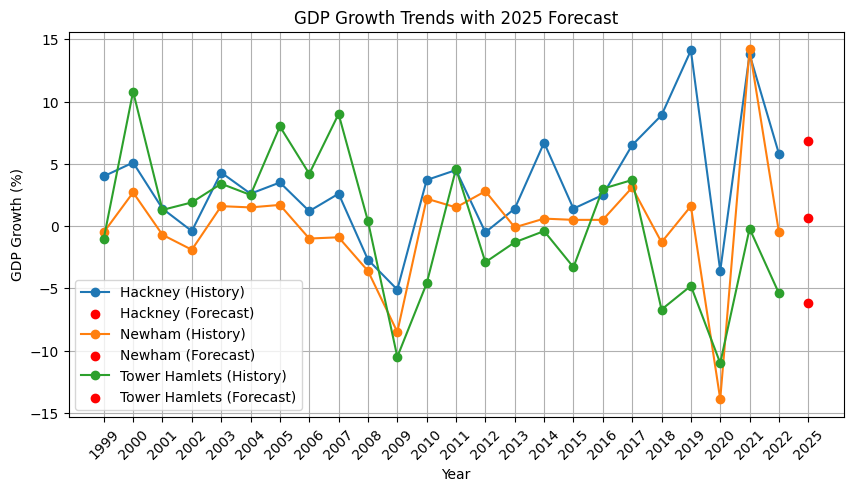

In [14]:
import matplotlib.pyplot as plt

# Select four LADs to visualise
selected_lads = ["Hackney", "Newham", "Tower Hamlets"]

# Plot historical data + 2025 forecast
plt.figure(figsize=(10, 5))

for lad in selected_lads:
    if lad in lad_growth_gvt_england_melted.columns:
        years = lad_growth_gvt_england_melted.index.astype(str)  # Convert PeriodIndex to str
        values = lad_growth_gvt_england_melted[lad]
        
        # Plot historical values
        plt.plot(years, values, marker="o", linestyle="-", label=f"{lad} (History)")
        
        # Plot 2025 forecast as a separate point
        plt.scatter("2025", forecast_df.loc[lad, "Forecast_2025"], color="red", zorder=3, label=f"{lad} (Forecast)")

# Formatting
plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("GDP Growth (%)")
plt.title("GDP Growth Trends with 2025 Forecast")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
lad_growth_gvt_england


,Region,LA Code,LA Name,1999,2000,2001,2002,2003,2004,2005,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,North East,E06000001,Hartlepool,6.1,0.1,-0.4,2.0,2.0,0.6,-1.1,...,0.3,-2.9,5.4,7.5,-1.2,-3.4,-1.4,-3.7,-4.5,3.6
1,North East,E06000004,Stockton-on-Tees,4.4,0.2,0.7,1.5,4.4,4.7,-2.0,...,0.2,1.7,5.6,-0.5,-3.3,-0.2,2.6,-7.2,9.0,0.8
2,North East,E06000002,Middlesbrough,4.3,1.9,0.4,1.5,3.8,5.6,2.3,...,-2.4,1.1,2.9,2.7,3.7,4.7,-3.1,-19.1,17.3,3.8
3,North East,E06000003,Redcar and Cleveland,4.0,2.5,-2.4,2.7,5.9,-0.6,-1.2,...,-2.2,3.8,2.9,-4.8,-7.3,2.7,-0.3,-7.6,0.7,3.4
4,North East,E06000005,Darlington,7.6,15.2,11.0,8.5,9.3,8.8,-0.5,...,1.7,15.9,10.5,-3.3,1.6,2.7,-0.9,-13.2,13.1,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,South West,E07000043,North Devon,6.6,0.2,0.9,1.6,0.8,2.4,1.1,...,0.9,1.2,4.6,-1.3,0.6,-0.2,0.0,-15.3,16.7,3.5
292,South West,E07000044,South Hams,4.5,5.4,6.6,3.7,5.9,6.1,2.8,...,1.4,7.4,2.0,0.2,1.3,3.3,-0.4,-10.0,17.4,3.1
293,South West,E07000045,Teignbridge,1.5,0.6,0.2,1.2,0.7,3.2,-0.3,...,1.9,5.9,-0.5,1.0,3.5,-3.9,0.0,-15.4,20.1,4.4
294,South West,E07000046,Torridge,3.4,0.9,2.5,3.2,-0.7,3.2,2.4,...,-0.4,5.6,-5.3,-0.5,2.4,-3.2,1.1,-13.6,15.0,6.9


In [16]:
forecast_df

,Forecast_2025
Adur,1.189144
Amber Valley,1.360275
Arun,0.779188
Ashfield,-1.352001
Ashford,-0.201232
...,...
Worthing,7.003155
Wychavon,0.053376
Wyre,1.160146
Wyre Forest,-0.272024


In [17]:
forecast_df = forecast_df.reset_index()
forecast_df.rename(columns={'index': 'LA Name'}, inplace=True)

# Merge the dataframes on 'LA Name'
merged_df = lad_growth_gvt_england.merge(forecast_df, on='LA Name', how='left')
merged_df

,Region,LA Code,LA Name,1999,2000,2001,2002,2003,2004,2005,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Forecast_2025
0,North East,E06000001,Hartlepool,6.1,0.1,-0.4,2.0,2.0,0.6,-1.1,...,-2.9,5.4,7.5,-1.2,-3.4,-1.4,-3.7,-4.5,3.6,-1.113149
1,North East,E06000004,Stockton-on-Tees,4.4,0.2,0.7,1.5,4.4,4.7,-2.0,...,1.7,5.6,-0.5,-3.3,-0.2,2.6,-7.2,9.0,0.8,0.166565
2,North East,E06000002,Middlesbrough,4.3,1.9,0.4,1.5,3.8,5.6,2.3,...,1.1,2.9,2.7,3.7,4.7,-3.1,-19.1,17.3,3.8,0.501925
3,North East,E06000003,Redcar and Cleveland,4.0,2.5,-2.4,2.7,5.9,-0.6,-1.2,...,3.8,2.9,-4.8,-7.3,2.7,-0.3,-7.6,0.7,3.4,-1.706624
4,North East,E06000005,Darlington,7.6,15.2,11.0,8.5,9.3,8.8,-0.5,...,15.9,10.5,-3.3,1.6,2.7,-0.9,-13.2,13.1,3.7,-0.484855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,South West,E07000043,North Devon,6.6,0.2,0.9,1.6,0.8,2.4,1.1,...,1.2,4.6,-1.3,0.6,-0.2,0.0,-15.3,16.7,3.5,0.653171
292,South West,E07000044,South Hams,4.5,5.4,6.6,3.7,5.9,6.1,2.8,...,7.4,2.0,0.2,1.3,3.3,-0.4,-10.0,17.4,3.1,1.533144
293,South West,E07000045,Teignbridge,1.5,0.6,0.2,1.2,0.7,3.2,-0.3,...,5.9,-0.5,1.0,3.5,-3.9,0.0,-15.4,20.1,4.4,2.295768
294,South West,E07000046,Torridge,3.4,0.9,2.5,3.2,-0.7,3.2,2.4,...,5.6,-5.3,-0.5,2.4,-3.2,1.1,-13.6,15.0,6.9,0.779536


In [18]:
merged_df = merged_df.rename(columns={"Forecast_2025": "2025"}).copy()
merged_df

,Region,LA Code,LA Name,1999,2000,2001,2002,2003,2004,2005,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2025
0,North East,E06000001,Hartlepool,6.1,0.1,-0.4,2.0,2.0,0.6,-1.1,...,-2.9,5.4,7.5,-1.2,-3.4,-1.4,-3.7,-4.5,3.6,-1.113149
1,North East,E06000004,Stockton-on-Tees,4.4,0.2,0.7,1.5,4.4,4.7,-2.0,...,1.7,5.6,-0.5,-3.3,-0.2,2.6,-7.2,9.0,0.8,0.166565
2,North East,E06000002,Middlesbrough,4.3,1.9,0.4,1.5,3.8,5.6,2.3,...,1.1,2.9,2.7,3.7,4.7,-3.1,-19.1,17.3,3.8,0.501925
3,North East,E06000003,Redcar and Cleveland,4.0,2.5,-2.4,2.7,5.9,-0.6,-1.2,...,3.8,2.9,-4.8,-7.3,2.7,-0.3,-7.6,0.7,3.4,-1.706624
4,North East,E06000005,Darlington,7.6,15.2,11.0,8.5,9.3,8.8,-0.5,...,15.9,10.5,-3.3,1.6,2.7,-0.9,-13.2,13.1,3.7,-0.484855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,South West,E07000043,North Devon,6.6,0.2,0.9,1.6,0.8,2.4,1.1,...,1.2,4.6,-1.3,0.6,-0.2,0.0,-15.3,16.7,3.5,0.653171
292,South West,E07000044,South Hams,4.5,5.4,6.6,3.7,5.9,6.1,2.8,...,7.4,2.0,0.2,1.3,3.3,-0.4,-10.0,17.4,3.1,1.533144
293,South West,E07000045,Teignbridge,1.5,0.6,0.2,1.2,0.7,3.2,-0.3,...,5.9,-0.5,1.0,3.5,-3.9,0.0,-15.4,20.1,4.4,2.295768
294,South West,E07000046,Torridge,3.4,0.9,2.5,3.2,-0.7,3.2,2.4,...,5.6,-5.3,-0.5,2.4,-3.2,1.1,-13.6,15.0,6.9,0.779536


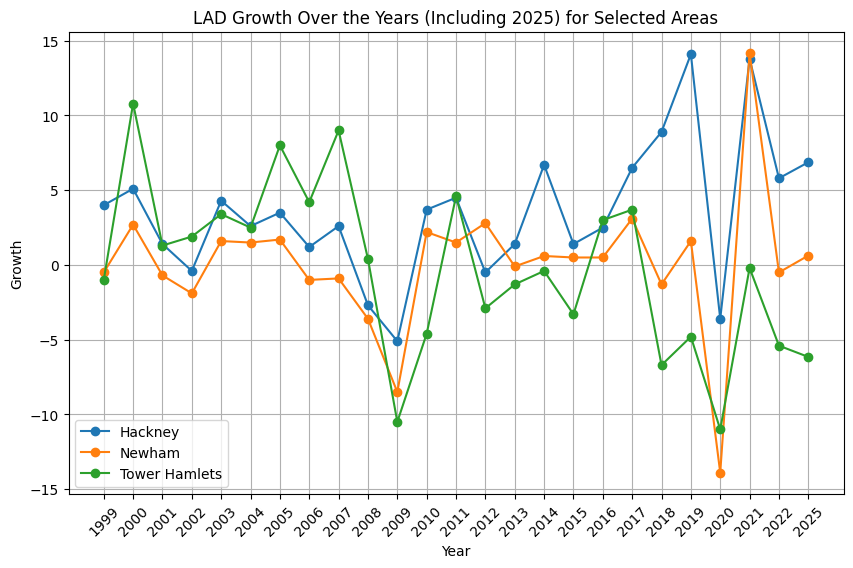

In [19]:
if "2025" not in merged_df.columns:
    print("2025 data is missing! Check the merging step.")
else:
    # Define the selected LADs
    selected_lads = ["Hackney", "Newham", "Tower Hamlets"]

    # Filter the dataset for selected LADs
    filtered_df = merged_df[merged_df["LA Name"].isin(selected_lads)]

    # Select only numeric year columns (including 2025)
    year_columns = [col for col in merged_df.columns if col.isdigit()]
    filtered_df = filtered_df.set_index("LA Name")[year_columns].T

    # Plot the data
    plt.figure(figsize=(10, 6))
    for lad in selected_lads:
        plt.plot(filtered_df.index, filtered_df[lad], marker="o", linestyle="-", label=lad)

    plt.title("LAD Growth Over the Years (Including 2025) for Selected Areas")
    plt.xlabel("Year")
    plt.ylabel("Growth")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

The prediction for 2025 appears reasonable as it follows the established trends observed in previous years, maintaining the fluctuations seen in the historical data. The dataset captures economic variations, including significant dips around 2008 (financial crisis) and 2020 (COVID-19 impact), with recovery trends thereafter. The forecast does not introduce unrealistic deviations but rather extends the existing patterns, showing moderate growth variations aligned with past cycles. The predicted decline for Tower Hamlets in 2025 appears reasonable when considering its historical fluctuations. The borough has shown significant volatility over the years, particularly with sharp dips around economic downturns (e.g., 2008 financial crisis, 2020 COVID-19 recession). Unlike Hackney and Newham, which show steadier recoveries, Tower Hamlets has a more variable trajectory confirmeing the reasonable choice of statistical modelling.

In [20]:
merged_df.to_csv(output_path, index=False)
print(f"CSV saved at: {output_path}")

CSV saved at: /work/LADS_data/lad_growth_with_forecast.csv


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cfb480dc-687e-4482-b857-be10c729aa58' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>